# Integrating AIR and transcriptomics
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} air_repertoire.yml
:language: yaml
```
````

`````
``````
<!-- END DROPDOWNS -->


```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: air-repertoire-multimodal-integration-key-takeaway-1
:link-type: ref
For multimodal datasets of AIR and GEX, typically, one modality is used for grouping the cells to perform standard uni-modal analysis on the other modality (e.g. Sequence analysis on leiden clusters).
:::

:::{card}
:link: air-repertoire-multimodal-integration-key-takeaway-2
:link-type: ref
Cell functionality (determined by AIR) and cell state (observed via GEX) are interlinked.
It has been shown, that cells with alike AIR sequences can share similar phenotypes.
:::

:::{card}
:link: air-repertoire-multimodal-integration-key-takeaway-3
:link-type: ref
Due to the inherent structural difference between count matrices (GEX) and amino acid sequences (IR), it is difficult to directly fuse both modalities.
Therefore, several methods were developed recently, to utilize paired GEX-AIR data for to derive clusters, or an embedding.
However, these approaches are still novel and not part of a standard analysis pipeline.
:::

```

<!-- START ENV-SETUP -->
<!-- END ENV-SETUP -->

## Motivation

With the development of novel single cell technology, AIRR sequencing is combined often with other omics layers such as with transcriptomics. For B- and T-cells this enables the analysis of various characteristics on a single cell level: while the transcriptome provides insights into the current state of the cell, the AIR is indicative for the cell's specificity and thereby explains the cell's fate upon infection or vaccination. 

## Data Preparation

First, we will combine the GEX with AIR data. Note, that we can do this also at earlier stages of single cell analysis: e.g. we can fuse both modalities already before preprocessing to filter GEX doublets. When fusing GEX and AIR data, a left join is often performed. I.e., only cells with GEX are kept for analysis. Therefore, the order of fusing and filtering is not of great importance. However, it can be convenient to visualize the AIR information in an GEX UMAP in early stages. E.g. missing AIR information in clusters can help during cell type assignment.

:::{warning}
Scirpy changed the format of [its datastructure](https://scirpy.scverse.org/en/latest/data-structure.html#storing-airr-rearrangement-data-in-anndata)
with v0.13. While the overall analysis workflow has not changed, some outputs shown in this chapter might not be accurate anymore. 

See [the scirpy release notes](https://scirpy.scverse.org/en/latest/changelog.html#v0-13-0-new-data-structure-based-on-awkward-arrays) for more details about this change. 
Until we update this chapter, please also refer to the [official scirpy documentation](https://scirpy.scverse.org).
:::

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
path_data = "./data"
path_gex_tcr = f"{path_data}/TCR_00_GEX.h5ad"
path_gex_bcr = f"{path_data}/BCR_00_GEX.h5ad"
path_tcr = f"{path_data}/TCR_01_preprocessed.h5ad"
path_bcr = f"{path_data}/BCR_01_preprocessed.h5ad"

path_tmp = f"{path_data}/tmp"
path_res = f"{path_data}/res"

First we will load the Gene expression data processed by the authors. You can download the full dataset from https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.4.zip . Since we are working only with the B- and T-cells of selected donors, we provide a downsampled dataset for you:

! wget -O $path_bcr_input -nc https://figshare.com/ndownloader/files/35574338

! wget -O $path_bcr_input -nc https://figshare.com/ndownloader/files/35574338

Let's load the GEX and the previously annotated TCR data. Both AnnData objects can then easily be merged via scirpy into a shared AnnData object, which will store the AIR information in `adata.obs` and GEX in `adata.X`. Here a left join is conducted: only AIRs from cells with scRNA data, are added to the AnnData object. Cells with scRNA but without AIR are often kept during analysis, because it can include cells other than B- and T-cells. However, cells with AIR but without scRNA are clearly missing the measurements. Since a majority of downstream analysis is conducted on transcriptomics level, these cells are excluded.

In [3]:
adata_tc = sc.read(path_gex_tcr)
adata_tcr = sc.read(path_tcr)

ir.pp.merge_with_ir(adata_tc, adata_tcr)

Let's calculate Leiden clustering on the T cell transcriptome.

In [4]:
sc.pp.neighbors(adata_tc)
sc.tl.leiden(adata_tc)

To get an overview, we will plot the data with cluster assignment as a UMAP visualisation.

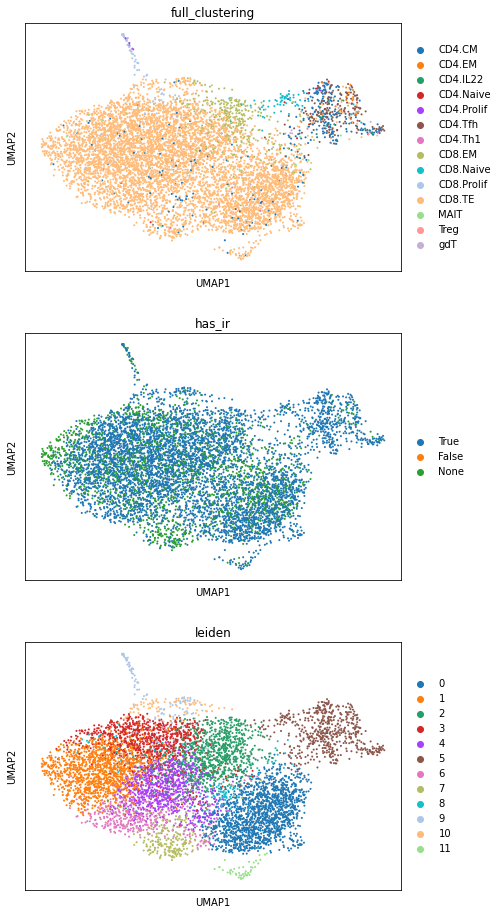

In [5]:
sc.tl.umap(adata_tc)
sc.pl.umap(adata_tc, color=["full_clustering", "has_ir", "leiden"], ncols=1)

Here, we can see, that the majority of cells belong to the CD8+ effector T cells. Also, most of the cells express an TCR. The presence of AIRs can guide cell type annotation to separate clusters of other immune cells from T- and B-cells. Additional, missing AIRs can also be used for quality control: e.g. if the data is sorted for T cells, but large clusters miss TCRs, it should be investigated on a transcriptomic level, whether these cells were wrongly sorted.

Similar, we merge with the BCR and GEX data for B cells.

In [6]:
adata_bc = sc.read(path_gex_bcr)
adata_bcr = sc.read(path_bcr)

ir.pp.merge_with_ir(adata_bc, adata_bcr)

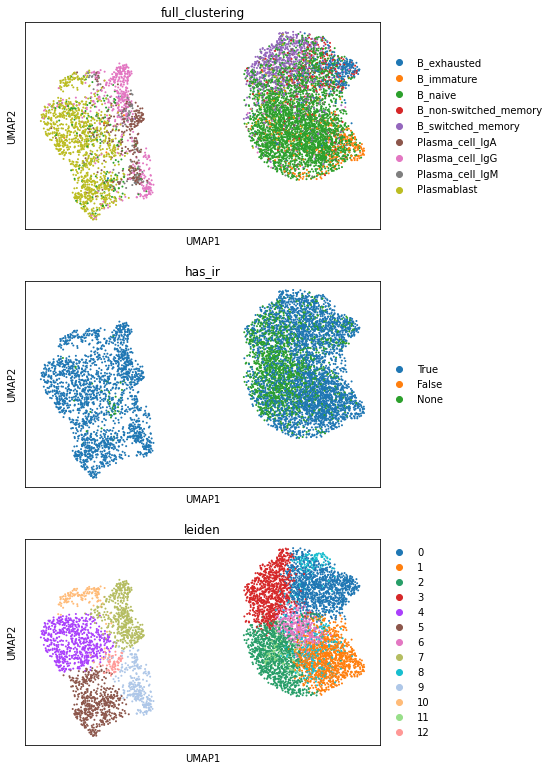

In [7]:
sc.pp.neighbors(adata_bc)
sc.tl.leiden(adata_bc)
sc.tl.umap(adata_bc)
sc.pl.umap(adata_bc, color=["full_clustering", "has_ir", "leiden"], ncols=1)

In this visualization, we see a clear separation between Plasmablasts and B cells.

(air-repertoire-multimodal-integration-key-takeaway-1)=
## Uni-modal Analysis with multimodal conditions

While studies often provide paired measurements for both modalities, these are often analyzed individually utilizing only limited shared information. Often one modality (AIRR or transcriptome) is used to provide conditions, on which the other modality is then analyzed. E.g., we can observe how cells from the same clonal lineage adapt to perturbation by DEG analysis of these cells in different points in time. 

Previously, we covered these unimodal analysis in other sections of this book. Here, we will focus, on how we can apply these techniques across AIRR and other modalities, rather than explaining the underlying approaches. To find a more detailed explanation please refer to the corresponding chapters.

### AIR analysis on RNA clusters

We have shown sequence and diversity analysis of AIRs in chapter {ref}`air:sequence`. When paired AIRR- and transcriptome data is available, we can perform similar analysis on cell clusters defined in the scRNA-space. How these scRNA-clusters are defined, is depending on the study design. Selected ways to define scRNA clusters for AIR analysis may include:

- **Leiden Clusters**: Arguably, the easiest way to define subsets of cells within count data, is via clustering algorithms. Usually, Leiden clustering is performed and highly expressed genes of the clusters are used to determine the cells' state. We can now conduct the AIRR analysis on clusters of interest (e.g. an activated cluster that is likely disease-specific). 
- **Marker Genes**: We can select cells based on specific marker genes, that are indicative for specific cell states. Depending on your research questions, you should select your marker genes accordingly (e.g. markers for proliferation, activation, suppression, ...). Naturally, this also extends to scores defined on collections of marker genes.
- **Cell Types**: Several sub cell types exist for B- and T-Cells for various degrees of hierarchy. After these cell types are annotated via transcriptome or other modalities, we can investigate how the repertoire composition differs among this label. This analysis can either be performed within sample (how does the repertoire differ between cell types) or within a cell type across samples (e.g. how does the repertoire of CD8<sup>+</sup> effector T-cells change between disease and healthy patients).

**Leiden Clusters**: Above we clustered the gene expression data via the Leiden algorithm. We can now use the resulting groups to performance any kind of sequence analysis, e.g. spectratyping. For that, we simply define the group parameter (here: color) with the column name of the Leiden clustering ("leiden").

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_junction_aa by leiden'}, xlabel='IR_VJ_1_junction_aa length'>

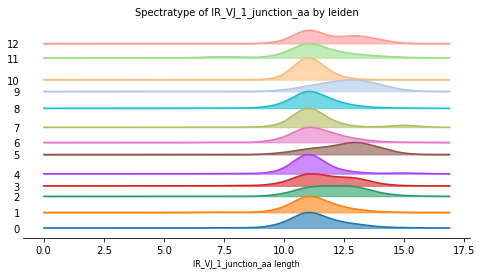

In [8]:
ir.pl.spectratype(
    adata_bc,
    color="leiden",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [8, 4]},
    kde_kws={"kde_norm": False},
)

The BCR length of most Leiden clusters follows a similar distribution. However, it is clear to see, that cluster 5 and 9 mainly contain BCRs with longer sequence length. These cells stem from a subcluster of Plasmablasts and Plasma cells. A diverging length profile can be caused by an immune reaction. It might therefore be useful to further investigate these clusters. #update interpretation after subsample decision.

**Marker Genes**: Next, we can define our groups based on individual genes. As an example, we here pick Interferon Gamma as a marker for pro-inflammatory immune response. This will provide us with a selection of cells which are currently initiating an immune response. 

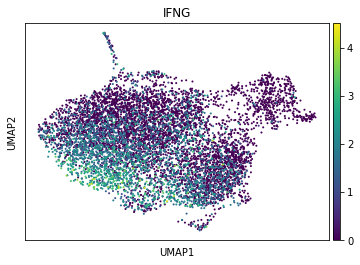

In [9]:
sc.pl.umap(adata_tc, color="IFNG")

When visualizing it, we observe, that it is present in a subset of CD8 effector T cells. Next, we will select cells with high IFNG (arbitrary threshold: 2.5) and annotate this selection in the AnnData object. To use it as category, we will store it as string. We can visualize the selected cells in the UMAP.

... storing 'elevated_IFNG' as categorical


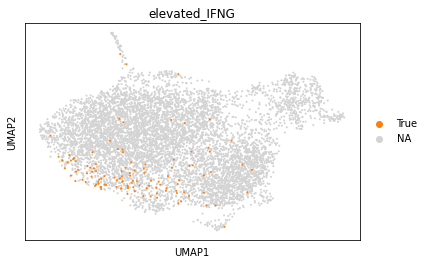

In [10]:
adata_tc.obs["elevated_IFNG"] = adata_tc[:, "IFNG"].X.todense() > 3
adata_tc.obs["elevated_IFNG"] = adata_tc.obs["elevated_IFNG"].astype(str)
sc.pl.umap(adata_tc, color="elevated_IFNG", groups="True")

Next, we will generate frequency plots to see, whether the TCRs from cells with elevated IFNg expression, follow specific sequence patterns compared to the remaining cells. First, we select all cells with annotated CDR3β, followed by separation into background cells and cells with elevated IFNG. Finally, we construct the motifs and plot them.

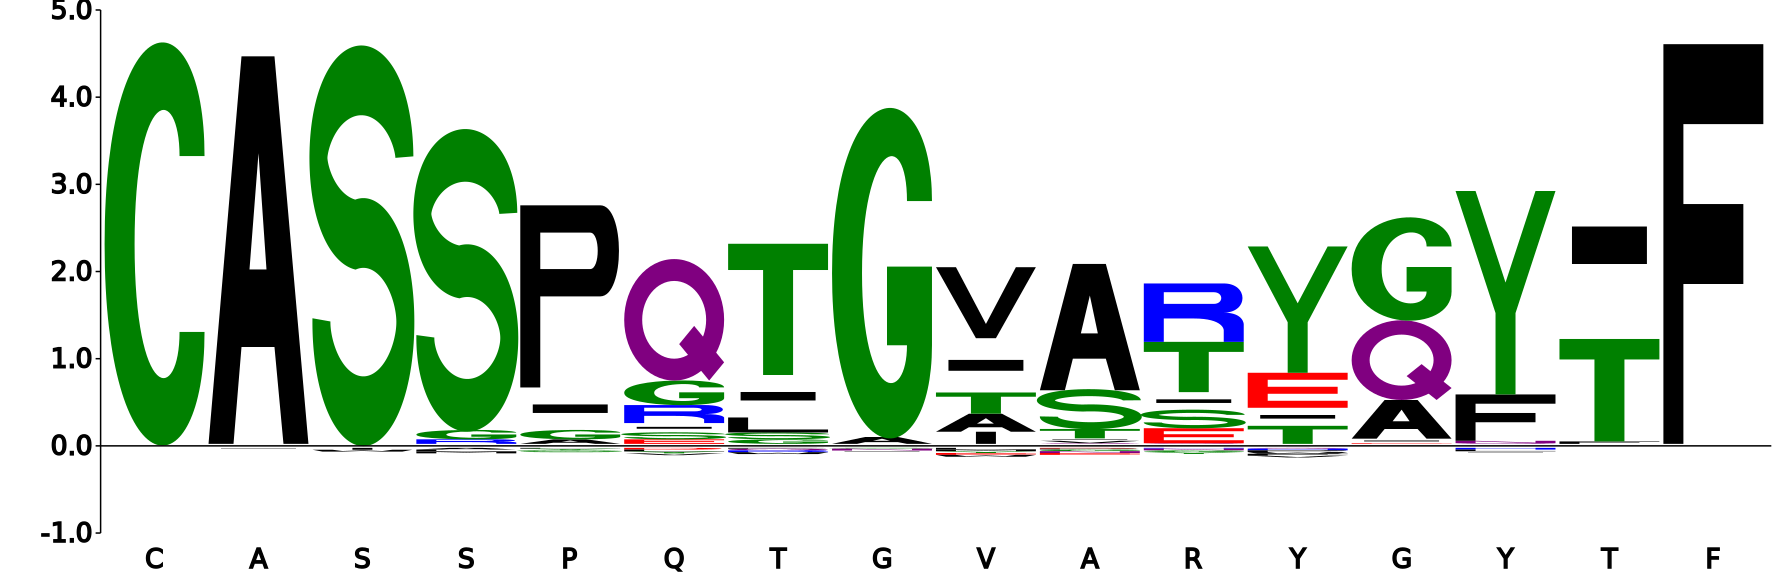

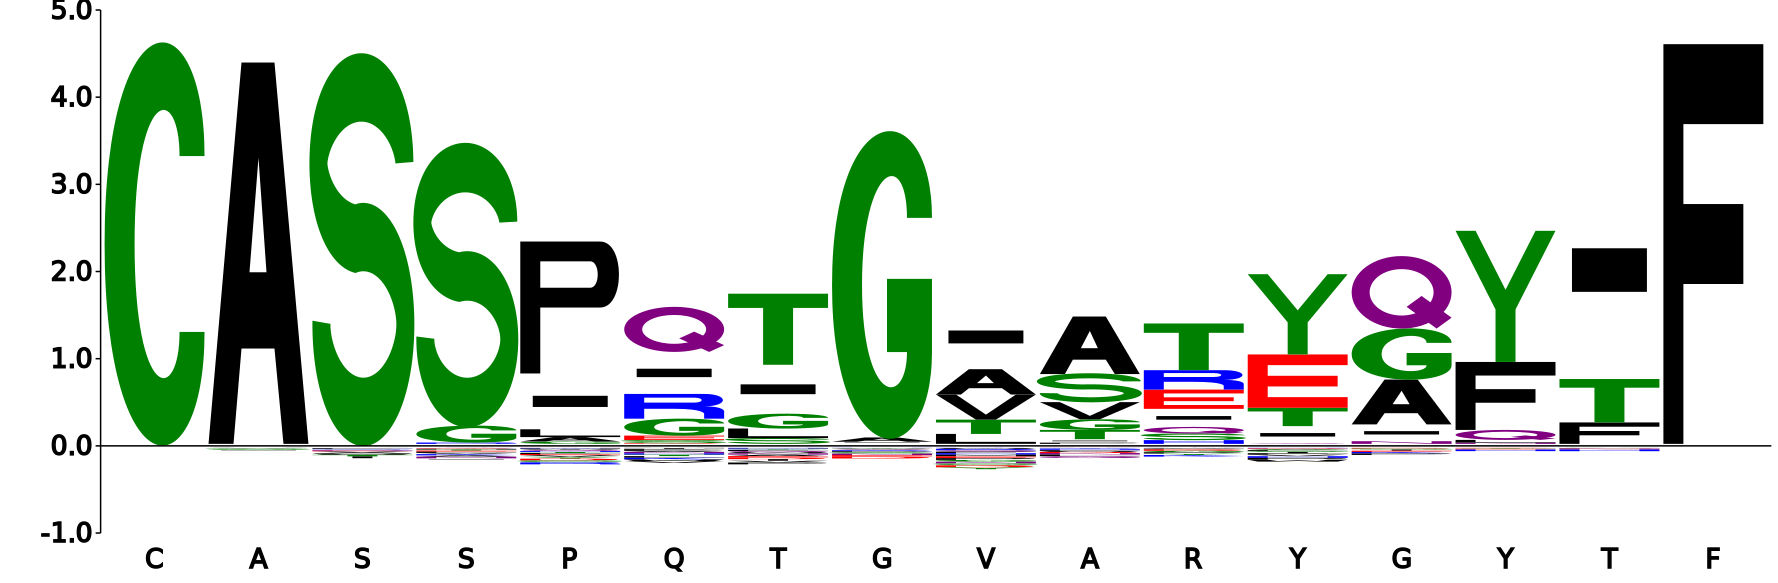

In [11]:
from IPython.display import SVG
from palmotif import compute_pal_motif, svg_logo

df_sequences = adata_tc[~adata_tc.obs["IR_VDJ_1_junction_aa"].isna()].obs[
    ["IR_VDJ_1_junction_aa", "elevated_IFNG"]
]

seqs_elevated = df_sequences[df_sequences["elevated_IFNG"] == "True"][
    "IR_VDJ_1_junction_aa"
]
seqs_background = df_sequences[df_sequences["elevated_IFNG"] == "False"][
    "IR_VDJ_1_junction_aa"
]
centroid = df_sequences["IR_VDJ_1_junction_aa"].value_counts().index[0]

motif_ifng, _ = compute_pal_motif(
    seqs=seqs_elevated,
    centroid=centroid,
)
motif_back, _ = compute_pal_motif(
    seqs=seqs_background,
    centroid=centroid,
)

svg_logo(motif_ifng, "tmp/motif_ifng.svg")
svg_logo(motif_back, "tmp/motif_back.svg")
display(SVG("tmp/motif_ifng.svg"))
display(SVG("tmp/motif_back.svg"))

While the frequency of amino acids at specific positions changes slightly, no large clear differing motifs can be seen between the two cell sets. Therefore, there doesn't exist any evidence, that the selected subset of T cells share specificity to the same target epitope.

**Cell Type**: Here, we apply the diversity between different cell types annotated on the transcriptomic level (stored in "full_clustering"). We see, that proliferating and effector CD8<sup>+</sup> T cells have the lowest diversity. Since these cell types contain larger clones, this was to be expected. Such an analysis could be used as a sanity check for the cell type assignment or to compare the diversity of cell types over multiple studies.

In [12]:
# TODO: remove clonotype definition once this is handled by clonotype chapter
# ir.pl.alpha_diversity(adata_tc, groupby="full_clustering", target_col="clone_id", figsize=[8, 4])

### GEX analysis on AIR clusters

Similarly, we can perform the standard analysis of transcriptome {ref}`differential-analysis`, but on groups derived in the AIR space. E.g.:

- **Clonotype**: AIR clonotypes can be used as clusters, if sufficient clonal expansion is present. This is especially intriguing, since the clonotype serves as a proxy for the cells specificity. Cells recognizing the same antigen can therefore be tracked over conditions such as time, treatment, or stimulation to observe their change.
- **Clonotype Network**: To increase the amount of cells to track, we can use networks of clonotypes with similar AIR sequence instead of clonotypes. While these cells are not ancestrally related, they are likely to share the same specificity.
- **Disease Specificity**: We previously queried databases, to detect epitope specific AIRs. We can now use this annotation, to investigate, how B- or T-cells reactive to selected diseases differ from other cells. Here, we must be cautious, since the dataset query provides us only with positive annotation: by same or similar AIR, we identify cells specific to a certain epitope. However, a missing pair of AIR and epitope in a database is not indicative of this binding being impossible.

As for the previous subsection, the selected condition and analysis are highly depended on your research question. In the previous notebooks, we annotated these conditions in ```adata.obs```. Since they can, hence, be applied for DEG analysis in the same fashion, we will only showcase DEG by #todo when the rest is unified.

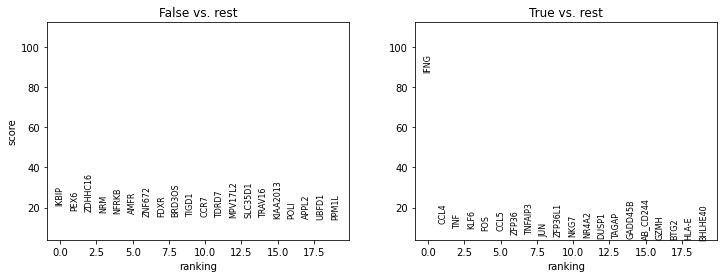

In [13]:
# todo change once load clonotype annotated data
sc.tl.rank_genes_groups(adata_tc, groupby="elevated_IFNG")
sc.pl.rank_genes_groups(adata_tc, groupby="elevated_IFNG")

In [14]:
# TODO adapt to disease specific cells => Covid B cells against rest

## Multimodal Integration

In the previous section we have shown, how modality specific analysis is performed on clusters derived from other modalities. However, this underutilizes the additional information provided by paired data, since AIRs and gene expression are interlinked: adaptive immune cells recognizing the same epitopes, will undergo a similar development upon activation. As for other Omics combinations, there has been an interest lately in integrating AIR and GEX for deriving clusters or a shared representation. 

These models are still novel and are not part of a standard "best-practice" analysis pipelines. We assume that these or similar approaches will be increasingly used in the future and therefore want to showcase these integration models as an outlook. However, you should be careful when applying these models, since they are still experimental and not independently evaluated for their strengths and weaknesses.

### Integrating TCR and GEX
Only recently, three methods were developed yet to jointly utilize TCR sequences and transcriptome each aiming at different aspects of analysis: 
- **TESSA**: applies a Bayesian model on a TCR and GEX embedding for clustering T cells of similar transcriptome and sequences.
- **Conga**: clusters T cell clones through a graph-theoretic approach by distances of GEX and TCR
- **mvTCR**: uses Deep Variational Autoencoders to derive a shared embedding of GEX and TCR.

All multimodal approaches, require paired GEX and AIR data. We will therefore start by filtering all cells without CDR3β. 

In [15]:
adata_tc = adata_tc[~adata_tc.obs["IR_VDJ_1_junction_aa"].isna()].copy()

#### TESSA

Zhang et al. developed TCR functional landscape estimation supervised with scRNA-seq analysis (TESSA) {cite}`zhang2021mapping`, which aims at embedding and clustering T cell clones based on their TCR sequence and transcriptome via Bayesian modelling. The CDR3β sequence is first compressed to a 30-dimensional numeric representation using a pretrained autoencoder. Following, the dimensions are upweighted to correlate the TCR representation with the gene expression of similar TCR-groups, thereby assigning importance of TCR position for explaining the cells' gene expression. In an interactive process, weights and groups are updated until convergence to reach a maximal alignment between both modalities.

TESSA produced clusters of high purity when embedding T-cells with known epitope specificity from {cite}`10x2019new`, surpassing the uni-modal model GLIPH {cite}`glanville2017identifying`, which is commonly used for clustering TCR sequences. Further, cluster centrality was indicative for higher avidity clones shown by clonal expansion and high ADT counts. Using TESSA on data from {cite}`yost2019clonal`, the author detected novel clusters of responder T cell in patients undergoing PD-1 blockade. 

The code and instructions for installation can be found [here](https://github.com/jcao89757/TESSA).

##### Data Preprocessing

TESSA requires several TCR and GEX files in specific format.

First, we save a ".csv"-File with the following columns:
- **contig_id**: cell barcodes as index column
- **cdr3**: CDR3β amino acid sequence trimmed of starting C and ending F

In [16]:
df_tcr = adata_tc.obs
df_tcr.index.name = "contig_id"

# trimm cdr3 sequence
df_tcr["cdr3"] = [seq[1:-1] for seq in df_tcr["IR_VDJ_1_junction_aa"]]

# select only columns needed
df_tcr = df_tcr[["cdr3"]]

df_tcr.to_csv(f"{path_tmp}/TESSA_tcrs.csv")
df_tcr.head(5)

,cdr3
contig_id,
S11_AAACCTGAGATTACCC-1,ASSLDARDRGRVTEAF
S11_AAACCTGGTAATTGGA-1,ASSPGTGTYGYT
S11_AAACCTGGTAGCACGA-1,ASSIPGAVHEQY
S11_AAACCTGGTCTCAACA-1,ASSLDARDRGRVTEAF
S11_AAACCTGTCGCCGTGA-1,ASSPQTGVARYGYT


We will filter the 10% most variable genes, as done in the TESSA publication.

In [17]:
n_genes = adata_tc.shape[1] // 10
sc.pp.highly_variable_genes(adata_tc, n_top_genes=n_genes)
adata_tessa = adata_tc[:, adata_tc.var["highly_variable"]].copy()

We now store the GEX matrix to a ".csv"-File. TESSA requires the transposed matrix of the adata object. I.e. the rows represent the different genes and the columns indicate a specific cell. For this, we will store the count data in a DataFrame with the right index and column names. Following, we transpose the DataFrame.

In [18]:
count_mat = adata_tessa.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_tessa.obs.index
df_counts.index.name = ""
df_counts.columns = adata_tessa.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f"{path_tmp}/TESSA_gex.csv")
df_counts.head()

,S11_AAACCTGAGATTACCC-1,S11_AAACCTGGTAATTGGA-1,S11_AAACCTGGTAGCACGA-1,S11_AAACCTGGTCTCAACA-1,S11_AAACCTGTCGCCGTGA-1,S11_AAACCTGTCTTATCTG-1,S11_AAACGGGCAAGAAAGG-1,S11_AAACGGGGTAGCGATG-1,S11_AAACGGGGTCGGCACT-1,S11_AAACGGGGTTACGGAG-1,...,S12_TTTGGTTGTCAGAGGT-1,S12_TTTGGTTTCAAGAAGT-1,S12_TTTGGTTTCTACTATC-1,S12_TTTGGTTTCTCGCTTG-1,S12_TTTGTCACACGGTAGA-1,S12_TTTGTCAGTAGAAAGG-1,S12_TTTGTCAGTCCAACTA-1,S12_TTTGTCAGTGAGTGAC-1,S12_TTTGTCATCCACTCCA-1,S12_TTTGTCATCGCATGAT-1
KLHL17,0.000000,0.0,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.662003,0.000000,0.0,0.000000,0.000000,0.0
HES4,0.000000,0.0,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
ISG15,1.845827,0.0,1.54457,2.441434,2.430966,0.9284,0.0,0.0,1.64661,1.565189,...,1.210719,0.0,1.581859,1.511785,0.000000,2.015501,0.0,2.088418,1.611682,0.0
AGRN,0.000000,0.0,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TTLL10,0.000000,0.0,0.00000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


##### Running the model

We need to provide different setting options, most of which specify input or output directories. We will summarize them in a dictionary first.

In [19]:
settings_full = {
    # Input files
    "tcr": f"{path_tmp}/TESSA_tcrs.csv",
    "exp": f"{path_tmp}/TESSA_gex.csv",
    # TESSA models
    "model": "TESSA/BriseisEncoder/TrainedEncoder.h5",
    "embeding_vectors": "TESSA/BriseisEncoder/Atchley_factors.csv",
    # Output files
    "output_TCR": f"{path_res}/TESSA_tcr_embedding.csv",
    "output_log": f"{path_res}/TESSA_log.log",
    "output_tessa": f"{path_res}",
    "within_sample_networks": "FALSE",
}

In the next step, we will create the command for running TESSA by specifying the environment and adding the settings.

In [20]:
cmd_tessa = "source ~/.bashrc &&"
cmd_tessa += "conda activate TESSA && "

cmd_tessa += "python TESSA/Tessa_main.py"
for key, value in settings_full.items():
    cmd_tessa += f" -{key} {value}"
cmd_tessa

'source ~/.bashrc &&conda activate TESSA && python TESSA/Tessa_main.py -tcr ./data/tmp/TESSA_tcrs.csv -exp ./data/tmp/TESSA_gex.csv -model TESSA/BriseisEncoder/TrainedEncoder.h5 -embeding_vectors TESSA/BriseisEncoder/Atchley_factors.csv -output_TCR ./data/res/TESSA_tcr_embedding.csv -output_log ./data/res/TESSA_log.log -output_tessa ./data/res -within_sample_networks FALSE'

Finally, we run the model on the specified settings by calling the command. Depending on your compute ressources this might take several minutes. Since the command line output is very verbose, we will silence this cell via the capture line magic.You should remove the first line for debugging.

In [21]:
%%capture
!$cmd_tessa

(air-repertoire-multimodal-integration-key-takeaway-2)=
##### Output

We now recieve three output files that we can further use for downstream tasks:
- **TESSA_tcr_embedding.csv**: Embedding of TCRs (without GEX information)
- **result_meta.csv**: cluster assignment by cell
- **tessa_final.RData**: Containing inferred model parameters (e.g. weighting vector b)

Here, we will use the first two files as embedding and clustering. We will store them in AnnData format for easier handling. To avoid the clustering to be dominated by highly expanded clones, we reduce the cell-level data to a clone-level by removing duplicate TCRs.

In [22]:
tessa_embedding = pd.read_csv(f"{path_res}/TESSA_tcr_embedding.csv", index_col=0)
tessa_embedding = tessa_embedding.drop_duplicates()
tessa_obs = adata_tc[adata_tc.obs.index.isin(tessa_embedding.index)].obs
tessa_embedding = sc.AnnData(X=tessa_embedding.values, obs=tessa_obs)

Next, we will add the TESSA cluster assignment to the AnnData object. Since TESSA internally changes the barcode slightly, we will need to adjust for that. Additionally, we drop the duplicate TCRs within a cluster.

In [23]:
clustering = pd.read_csv(f"{path_res}/result_meta.csv", index_col=0)
clustering.index = clustering.index.str.replace(".", "-")
clustering = clustering[clustering.index.isin(tessa_embedding.obs.index)]
tessa_embedding.obs["TESSA_cluster"] = clustering["cluster_number"].values

print(f"Unique clones: {tessa_embedding.obs['cdr3'].nunique()}")
print(f"Unique clusters: {tessa_embedding.obs['TESSA_cluster'].nunique()}")

Unique clones: 751
Unique clusters: 134


You can see, that 751 clones were grouped to 144 clusters, which have similar TCR sequences and are likely to be functionally related. For TSNE visualisation, we will highlight the ten largest clusters in the TCR embedding space.

... storing 'TESSA_cluster' as categorical
... storing 'TESSA_cluster_top10' as categorical


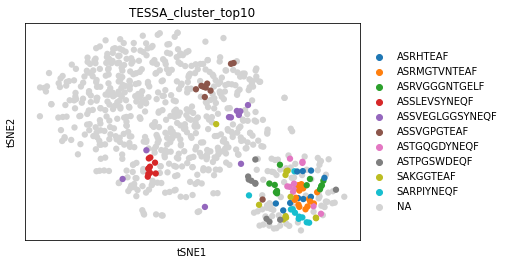

In [24]:
sc.pp.neighbors(tessa_embedding)
sc.tl.tsne(tessa_embedding)

top_10_clusters = tessa_embedding.obs["TESSA_cluster"].value_counts().head(10).index
tessa_embedding.obs["TESSA_cluster_top10"] = tessa_embedding.obs["TESSA_cluster"].apply(
    lambda x: x if x in top_10_clusters else np.nan
)

sc.pl.tsne(tessa_embedding, color="TESSA_cluster_top10")

For plotting the cluster assignment in the GEX space, we add the assignment to the original adata object. When plotting, we can see that TESSA clusters also share similar phenotypes at GEX level.

... storing 'cdr3' as categorical
... storing 'TESSA_cluster_top10' as categorical


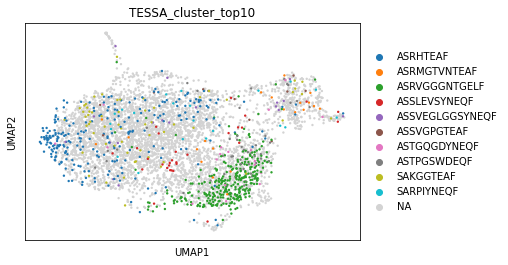

In [25]:
mapping_dict = dict(
    tessa_embedding.obs[["IR_VDJ_1_junction_aa", "TESSA_cluster_top10"]].values
)
adata_tc.obs["TESSA_cluster_top10"] = adata_tc.obs["IR_VDJ_1_junction_aa"].map(
    mapping_dict
)
sc.pl.umap(adata_tc, color="TESSA_cluster_top10")

In both visualisations, we can see that the clusters are related on a TCR and GEX level. However, the full clustering can not directly observed in a single modality. Due to similar TCR and GEX profile, these cells might be specific to the same epitopes. As an example, we could use this annotation for DEG analysis between cell networks as described above.

#### CoNGA

clonotype neighbor graph analysis (CoNGA) {cite}`schattgen2022integrating` uses similarity graphs at a clonotype level on GEX and TCR, for which the well known distance metric TCRDist {cite}`dash2017quantifiable` is used. Based on the graph neighborhood, clusters are formed by shared GEX and TCR assignments. These so called "CoNGA clusters" thereby share similar receptor sequences as well as similar gene expression. CoNGA clusters contained clonotypes with highly alike TCRs based on e.g. length and physio-chemical properties and were shown to capture specificity. The following explanation runs the main CoNGA pipeline. Since the different aspects of the pipeline are explained [here](https://github.com/phbradley/conga/blob/master/colab_conga_pipeline.ipynb), the following description is mainly focused on how to transform the data and run the pipeline.

##### Data Preparation

CoNGA conveniently supports several input types for the gene expression matrix including h5ad-files. For the clonotype information, we need to create a clone_file first by running a preprocessing script on the Cell Ranger output.

In [26]:
df_tcr = pd.read_csv(
    f"{path_data}/TCR_00_read_aligned.csv",
    # index_col='barcode',
)
df_tcr = df_tcr.drop("Unnamed: 0", axis=1)
df_tcr = df_tcr[df_tcr["barcode"].isin(adata_tc.obs.index)]

path_reduced_tcr = f"{path_tmp}/conga_tcrs.csv"
df_tcr.to_csv(path_reduced_tcr)

path_conga_clones = f"{path_tmp}/conga_clone_file.tsv"

In [27]:
cmd_conga_pp = (
    "python conga/scripts/setup_10x_for_conga.py "
    f"--filtered_contig_annotations_csvfile {path_reduced_tcr} "
    f"--output_clones_file {path_conga_clones} "
    "--organism human"
)

In [28]:
%%capture
!$cmd_conga_pp

The CoNGA pipeline requires unlogged counts for the gene expression. Since this is not provided in our SARS-CoV-2 dataset, we will revert the log1p transformation by its inverse and save the results to a separate file. If you run the analysis on your own dataset, you can directly link to your raw count data.

In [29]:
path_conga_gex = f"{path_tmp}/conga_gex.h5ad"

adata_conga = adata_tc.copy()
adata_conga.X = np.expm1(adata_tc.X)
sc.write(adata=adata_conga, filename=path_conga_gex)

##### Executing CoNGA

We can execute the main CoNGA pipeline via the following command line call, which specifies the input and output directories.

In [30]:
cmd_conga = f"cd {path_res} && "

cmd_conga += (
    "python ../../conga/scripts/run_conga.py "
    f"--graph_vs_graph --graph_vs_graph_stats --graph_vs_features --tcr_clumping --find_hotspot_features "
    f"--gex_data ../../{path_conga_gex} --gex_data_type h5ad "
    f"--clones_file ../../{path_conga_clones} "
    f"--organism human --outfile_prefix conga"
)

In [31]:
%%capture
!$cmd_conga

##### Output

The results of the pipeline are stored in  ```./data/res/conga_results_summary.html``` with an explanation for each result. Additional annotation and plots are available under ```./data/res_conga/```. Explaining all results, is out of scope of this tutorial. We, therefore, refer to the very detailed explanation in the web summary and the colab notebook.

(air-repertoire-multimodal-integration-key-takeaway-3)=
#### mvTCR

mvTCR by An et al. is a multiview Variational autoencoder that compresses TCR sequence and gene expression into a lower-dimensional representation {cite}`an2021jointly`. Two deep learning architectures - Transformer and Multi-layer perceptron - extract information from both TCR and GEX, respectively, before they are fused to derive the joint space. Following, the trained models can be used to embed similar data. 

The authors showed, that multi-modal models can better capture antigen specificity, than uni-modal embeddings on the data from {cite}`10x2019new` for prediction and clustering. Additionally, they showed that cell type and cell functionality are preserved in the embedding space on a SARS-CoV-2 dataset from {cite}`fischer2021single`. Code and further explanations are available [here](https://github.com/SchubertLab/mvTCR).

mvTCR relies on the AnnData format and we therefore need to prepare our AnnData object for training. For that, the several functions are provided.

In [32]:
import sys

sys.path.append("mvTCR")
sys.path.append(".")

import tcr_embedding.utils_training as utils
from tcr_embedding.models.model_selection import run_model_selection
from tcr_embedding.utils_preprocessing import encode_tcr, group_shuffle_split

The AnnData object requires a clonotype assignment (see chapter {ref}`air:sequence`). Since mvTCR uses both chains of the primary receptor, we will use this information for defining the clonotype as well. # todo => use the one provided

In [33]:
adata_mvtcr = adata_tc[~adata_tc.obs["IR_VJ_1_junction_aa"].isna()].copy()

In [34]:
# todo delete once data is unified
ir.tl.define_clonotypes(
    adata_mvtcr, key_added="clonotype", receptor_arms="all", dual_ir="primary_only"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 795.39it/s]


The model requires a numeric encoding of the CDR3α and CDR3β chain. For that, we need to provide the columns containing the amino acid sequences. Additional, the pad attribute indicates the maximal length of the sequence. If we do not want to embed additional data afterwards, we can set it to the maximal sequence length.

In [35]:
pad = max(
    adata_mvtcr.obs["IR_VJ_1_junction_aa"].str.len().max(),
    adata_mvtcr.obs["IR_VDJ_1_junction_aa"].str.len().max(),
)
encode_tcr(
    adata_mvtcr,
    column_cdr3a="IR_VJ_1_junction_aa",
    column_cdr3b="IR_VDJ_1_junction_aa",
    pad=pad,
)

The data needs to be divided into a training and validation data. This is done by setting the values `train` or `val` for each cell in `adata.obs['set']`. By choosing the `clonotype` and 0.2, the dataset used to evaluate the model's performance will contain approximately 20% of unique clonotypes to the training set. This setting can generally be used for data analysis.

In [36]:
train, val = group_shuffle_split(adata_mvtcr, group_col="clonotype", val_split=0.2)
adata_mvtcr.obs["set"] = "train"
adata_mvtcr.obs.loc[val.obs.index, "set"] = "val"

We need to provide various information, that are used during training:

In [37]:
params_experiment = {
    "study_name": "test_haniffa",  # Name that identifies the study
    "model_name": "moe",  # Type of mixture model used during training, authors suggest using Mixture of Export (moe)
    "balanced_sampling": "clonotype",  # Column containing the id for clonotypes
    "comet_workspace": None,  # Can be used to log experiments via comet-ml
    "save_path": path_res,  # Output path, were the selected models are stored
}

mvTCR runs a hyperparameter optimization to choose the best model architecture. For general analysis, the optimization mode `pseudo_metric` is most suited. Here, the best model is determined by the capability of preserving multiple characteristics of the dataset. In the following, we choose identical TCR sequence (`clonotype`) and cell type (`functional.cluster`) both equally weighted (1 and 1). If after training the model, the latent space is dominated by one modality, we can rerun the model with different weightings.

In [38]:
params_optimization = {
    "name": "pseudo_metric",
    "prediction_labels": {"clonotype": 1, "full_clustering": 1},
}

Finally, we can run the model selection. Especially for larger datasets an extensive model search was used by the authors. As a showcase, we here only train one model. We recommend using a computer with GPU. Even then, the model will train several minutes.

In [39]:
n_runs = 1
run_model_selection(adata_mvtcr, params_experiment, params_optimization, n_runs)

[I 2022-11-17 13:46:07,144] A new study created in RDB with name: test_haniffa
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [08:12<00:00,  2.46s/it]
[I 2022-11-17 13:54:41,499] Trial 0 finished with value: 1.681318287535559 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1500, 'hdim': 200, 'shared_hidden': 100, 'rna_num_layers': 1, 'tfmr_encoding_layers': 4, 'loss_weights_kl': 4.0428727350273357e-07, 'loss_weights_tcr': 0.034702669886504146, 'lr': 1.0994335574766187e-05, 'zdim': 50, 'tfmr_embedding_size': 16, 'tfmr_num_heads': 8, 'tfmr_dropout': 0.15000000000000002}. Best is trial 0 with value: 1.681318287535559.


Study statistics:
  Number of finished trials: 1
  Number of pruned trials: 0
  Number of complete trials: 1
Best trial: 
  trial_0
  Value: 1.681318287535559


We now have a trained model, that we can use to embed data to a representation capturing TCR and GEX, simultaneously. For this, we will load the best model from our studies folder.

In [40]:
best_trial = 0
path_model = f"../data/res/trial_{best_trial}/best_model_by_metric.pt"
model = utils.load_model(adata_mvtcr, path_model)

In a next step, we can now embed this data and assign the annotation to our new embedded AnnData object.

In [41]:
mvtcr_embedding = model.get_latent(adata_mvtcr, metadata=[])
mvtcr_embedding.obs = adata_mvtcr.obs.copy()

This embedding can now be used for data analysis such as visualization. For this we will select the top 10 most abundant clonotypes within the sample.

In [42]:
top_10_clones = mvtcr_embedding.obs["clonotype"].value_counts().head(10).index
mvtcr_embedding.obs["clonotypes_top10"] = mvtcr_embedding.obs["clonotype"].apply(
    lambda x: x if x in top_10_clones else np.nan
)

Now, we will be using UMAPs to show cell type assignment and the top 10 clonotypes.

... storing 'clonotype' as categorical
... storing 'set' as categorical
... storing 'clonotypes_top10' as categorical


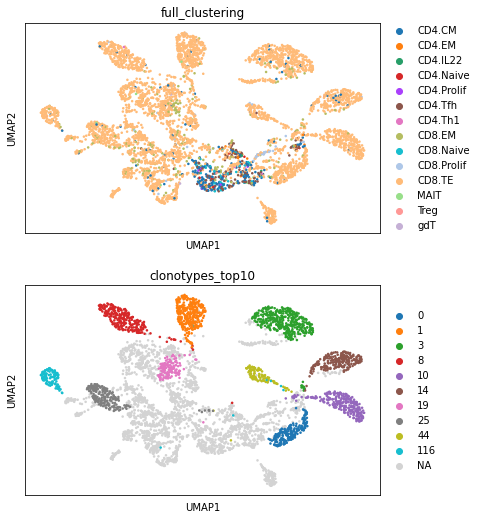

In [43]:
sc.pp.neighbors(mvtcr_embedding)
sc.tl.umap(mvtcr_embedding)
sc.pl.umap(mvtcr_embedding, color=["full_clustering", "clonotypes_top10"], ncols=1)

Here, we visualize the TCR-GEX embedding. It is clear to see, that the data separates by clonotype. However, the data forms additional subclusters and structures within the clones, which is influenced by the GEX. Depending on your analysis, you might need to adjust the weighting between GEX and TCR and run a longer parameter search. Otherwise, different downstream task such as clustering can now be performed on this embedding using Scanpy functions.

### Integrating BCR and GEX

The three models above were developed TCRs. However, Conga and mvTCR might be applicable for B cells due to similar structures of TCR and BCR. However, both models have not been evaluated for B cells in their publication. TESSA relies on a pre-trained TCR autoencoder and should therefore not be used for BCR-GEX integration. The authors recently published [Benisse](https://github.com/wooyongc/Benisse), which is similar to TESSA but applied on B cells {cite}`zhang2022interpreting`. 

Similar as for TCR, multimodal BCR integration tools are still novel and have not been used in standard analysis pipelines. Therefore, we recommend caution, when applying these models.

#### Benisse

Benisse embeds the heavy-chain of the BCR into a numeric embedding using a pre-trained model. The model works on a clonotype level: i.e., GEX of cells with the same BCR are averaged to form representative per clone. Following, Benisse detects clones that are similar on a BCR- and GEX-level by constructing a sparse graph structure.

Since the model has a similar setup as TESSA, we will follow the same processing steps and only comment, when details differ from above.

Due to long runtime, we first subsample the B-cell dataset to 1000 cells of one donor.

In [44]:
adata_benisse = adata_bc[~adata_bc.obs["IR_VDJ_1_junction_aa"].isna()]
adata_benisse = adata_benisse[adata_benisse.obs["sample_id"] == "MH9143275"]
sc.pp.subsample(adata_benisse, n_obs=1000, random_state=0)
print(f"Amount of cells: {len(adata_benisse)}")

Amount of cells: 1000


In [45]:
df_bcr = adata_benisse.obs
df_bcr.index.name = "contigs"

df_bcr = df_bcr.rename(columns={"IR_VDJ_1_junction_aa": "cdr3"})

df_bcr = df_bcr[["cdr3"]]

df_bcr.to_csv(f"{path_tmp}/BENISSE_bcrs.csv")
df_bcr.head(5)

,cdr3
contigs,
TTCTCAAAGAATTCCC-MH9143275,CAGGSQWEVKLDYW
TATCAGGAGTGAACAT-MH9143275,CARPRSLIAAAGAFDIW
CATCCACCAACGCACC-MH9143275,CASEEVTMVRGVMFPYGMDVW
GTCGTAATCACCGTAA-MH9143275,CAREGMVYVDYW
AACTCTTAGCACCGCT-MH9143275,CATQNPGYSSSWDDRGAFDIW


We will filter the 1,000 most variable genes, as provided in the sample data file in the GitHub repository.

In [46]:
sc.pp.highly_variable_genes(adata_benisse, n_top_genes=1000)
adata_benisse = adata_benisse[:, adata_benisse.var["highly_variable"]].copy()

count_mat = adata_benisse.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_benisse.obs.index
df_counts.index.name = ""
df_counts.columns = adata_benisse.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f"{path_tmp}/BENISSE_gex.csv")
df_counts.head()

,TTCTCAAAGAATTCCC-MH9143275,TATCAGGAGTGAACAT-MH9143275,CATCCACCAACGCACC-MH9143275,GTCGTAATCACCGTAA-MH9143275,AACTCTTAGCACCGCT-MH9143275,ACTATCTCACAGGAGT-MH9143275,CAGTAACCAGGAATCG-MH9143275,ACTGTCCTCTCGGACG-MH9143275,TCGGGACCAGCATGAG-MH9143275,ATTGGACAGCCATCGC-MH9143275,...,CACAGTAAGTGTCCAT-MH9143275,GTCAAGTCAAGGACTG-MH9143275,TAGTGGTAGCGATTCT-MH9143275,GTGCAGCGTCTCCCTA-MH9143275,CTGGTCTCATCCTTGC-MH9143275,CTTTGCGAGCTGCCCA-MH9143275,TACACGATCGGGAGTA-MH9143275,GGGCACTAGGATGTAT-MH9143275,TCACAAGGTGGTGTAG-MH9143275,TGCGCAGTCTCAAGTG-MH9143275
HES4,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CPTP,0.334078,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.44491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.565442,0.0,0.0,0.000000
THAP3,0.000000,0.0,0.0,0.225355,0.0,0.45654,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
VAMP3,0.334078,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.565442,0.0,0.0,0.000000
CASP9,0.000000,0.0,0.0,0.225355,0.0,0.00000,0.355897,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.291166


Unlike TESSA, BENISSE additionally requires an adapted contigs file as specified from the 10x cellranger output. Here, we will filter the original contigs file to contain only the barcodes of the selected donors.

In [47]:
path_bcr_contigs = f"{path_data}/BCR_00_read_aligned.csv"
df_bcr_contigs = pd.read_csv(path_bcr_contigs, index_col=0, low_memory=False)
df_bcr_contigs = df_bcr_contigs[df_bcr_contigs["barcode"].isin(adata_benisse.obs.index)]
df_bcr_contigs.to_csv(f"{path_tmp}/BENISSE_bcr_contigs.csv")

##### Running the model

First, we need to embed the BCR sequences via the pre-trained encoder:

In [48]:
settings_embedding = {
    "input_data": f"{path_tmp}/BENISSE_bcrs.csv",
    "output_data": f"{path_res}/BENISSE_encoded_bcrs.csv",
    "cuda": "True",
}

In [49]:
cmd_bcr_embedding = "source ~/.bashrc && "
cmd_bcr_embedding += "conda activate BENISSE && "

cmd_bcr_embedding += "python Benisse/AchillesEncoder.py"
for key, value in settings_embedding.items():
    cmd_bcr_embedding += f" --{key} {value}"
cmd_bcr_embedding

'source ~/.bashrc && conda activate BENISSE && python Benisse/AchillesEncoder.py --input_data ./data/tmp/BENISSE_bcrs.csv --output_data ./data/res/BENISSE_encoded_bcrs.csv --cuda True'

In [50]:
%%capture
!$cmd_bcr_embedding

Following, we need to create the graph representation. We will use the default values provided by the authors here.

In [51]:
max_iter = 100
cmd_benisse = [
    "source ~/.bashrc &&",
    "conda activate BENISSE &&",
    "export R_LIBS=$CONDA_PREFIX/lib/R/library &&",
    "Rscript Benisse/Benisse.R",
    f"{path_tmp}/BENISSE_gex.csv",
    f"{path_tmp}/BENISSE_bcr_contigs.csv",
    f"{path_res}/BENISSE_encoded_bcrs.csv",
    f"{path_res}",
    f"1610 1 {max_iter} 1 1 10 1e-10",
]
cmd_benisse = " ".join(cmd_benisse)
cmd_benisse

'source ~/.bashrc && conda activate BENISSE && export R_LIBS=$CONDA_PREFIX/lib/R/library && Rscript Benisse/Benisse.R ./data/tmp/BENISSE_gex.csv ./data/tmp/BENISSE_bcr_contigs.csv ./data/res/BENISSE_encoded_bcrs.csv ./data/res 1610 1 100 1 1 10 1e-10'

Even with reduced number of iteration, running the code might take several minutes.

In [52]:
%%capture
!$cmd_benisse

##### Output

We now receive several output files, which are described in more detail in the authors GitHub repository. In the following, we will examine:
- **connectionplot.pdf**: Visualisation of the derived clustering
- **clone_annotation.csv**: cluster assignment by cell

In [53]:
from IPython.display import IFrame

IFrame(f"{path_res}/connectionplot.pdf", width=600, height=600)

The connection plot provides us with a visualisation of the graph build by Benisse. Each clonotype is represented by a node in the learned embedding space. These clustering is informed by BCR as well as gene expression similarity.

... storing 'benisse_clusters' as categorical
... storing 'clusters_top10' as categorical


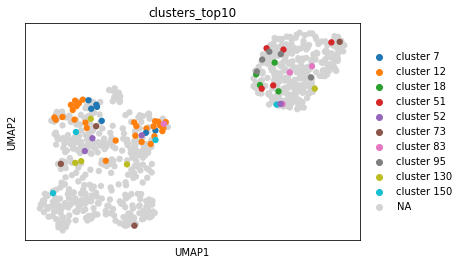

In [54]:
benisse_clusters = pd.read_csv(f"{path_res}/clone_annotation.csv", index_col=0)
benisse_clusters.index = [el.replace(".", "-") for el in benisse_clusters.index]
adata_benisse_out = adata_benisse[
    adata_benisse.obs.index.isin(benisse_clusters.index)
].copy()
adata_benisse_out.obs["benisse_clusters"] = benisse_clusters.loc[
    adata_benisse_out.obs.index
]["graph_label"]
sc.pp.neighbors(adata_benisse_out)
sc.tl.umap(adata_benisse_out)

top_10_clusters = (
    adata_benisse_out.obs["benisse_clusters"].value_counts().head(10).index
)
adata_benisse_out.obs["clusters_top10"] = adata_benisse_out.obs[
    "benisse_clusters"
].apply(lambda x: x if x in top_10_clusters else np.nan)
sc.pl.umap(adata_benisse_out, color="clusters_top10")

Here, we projected the ten largest clusters upon the transcriptome space. While some clusters follow the same phenotype, other clusters separate in the RNA space. The cluster annotation could be used for downstream analysis (see above) on BCR or transcriptomic site or to infer ancestral relationships between cells (see paper).

## Quiz

In [1]:
%run ../src/lib.py

flip_card(
    "q1",
    "Why could it be useful to integrate AIR sequence information with gene expression?",
    "GEX can be used to improve AIR sequence reads, both modalities provide different insights into the cell, while still being interdependent, etc.",
)
flip_card(
    "q2",
    "What information provides us the AIR sequence, that is not directly captured in GEX?",
    "A count matrix between cells and antibody-tagged epitope bindings, the IR sequence can be used for demultiplexing between different donors, etc.",
)
flip_card(
    "q3",
    "On what premise rely multi-modal integration approaches?",
    "Cells of same or alike AIRs often have a similar phenotype, information of AIR and GEX provide orthogonal information to each other, since they are independent, etc.",
    back_font_size=15,
)

## References

```{bibliography}
:filter: docname in docnames
```